In [ ]:
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# if you ve dataset in drive


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pshr123","key":"66545f56231ef5b656eb118f72d3b78f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd

/content


In [ ]:
!kaggle datasets download -d crawford/cat-dataset

100% 4.03G/4.04G [00:32<00:00, 185MB/s]
100% 4.04G/4.04G [00:32<00:00, 135MB/s]


In [ ]:
!unzip cat-dataset.zip

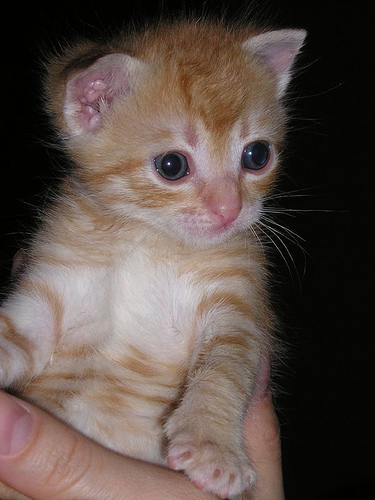

In [ ]:
import os, glob 
from IPython.display import Image


img_path = glob.glob(os.path.join("CAT_00","*.jpg"))

Image(img_path[0])

In [ ]:
# transformations
import numpy as np
import torchvision.transforms as transforms

std_dev = [.5 for i in range(3)]
mean = [.5 for i in range(3)]
size = (64, 64)

cat_transformation = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std_dev)
])
cat_transformation

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

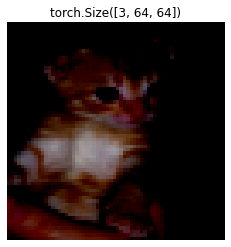

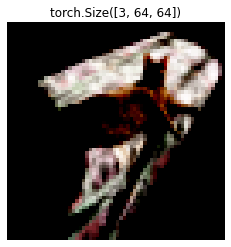

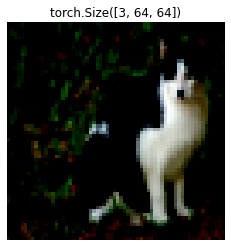

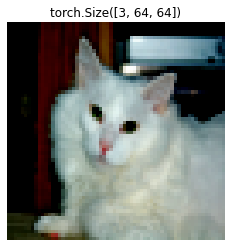

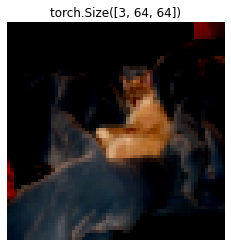

In [ ]:
from PIL import Image as PILImg
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

for i in range(5):
    img = PILImg.open(img_path[i])
    x = cat_transformation(img)
    plt.title(x.shape)
    plt.imshow(x.permute(1,2,0))
    plt.axis("off")
    plt.show()


In [ ]:
import torch.utils.data as data
from torch.utils.data import DataLoader

class CatDataset(data.Dataset):
    def __init__(self, images, transformation) -> None:
        self.images = images
        self.transformation = transformation
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = PILImg.open(self.images[index])
        return self.transformation(img)

In [ ]:
cat_data = CatDataset(img_path, cat_transformation)
batch_sz = 64
data_loader = DataLoader(cat_data, batch_sz, shuffle = True)

In [ ]:
next(iter(data_loader)).shape

torch.Size([64, 3, 64, 64])

In [ ]:
import torch
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, noise, img_sz=64) -> None:
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(noise, img_sz * 8, kernel_size=4, stride=1),  # inchannel
            nn.BatchNorm2d(img_sz * 8),
            nn.ReLU(inplace=True),
        )

        self.layer2 = self._blockLayer(
            img_sz * 8, img_sz * 4, kernel_sz=4, stride=2, pad=1
        )
        self.layer3 = self._blockLayer(
            img_sz * 4, img_sz * 2, kernel_sz=4, stride=2, pad=1
        )
        self.layer4 = self._blockLayer(img_sz * 2, img_sz, kernel_sz=4, stride=2, pad=1)

        self.terminating = nn.Sequential(
            nn.ConvTranspose2d(img_sz, 3, kernel_size=4, stride=2, padding=1), nn.Tanh()
        )

    def _blockLayer(self, in_ch, out_ch, kernel_sz, stride, pad):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_sz, stride, pad),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, noise):
        total_conv = nn.Sequential(
            self.layer1, self.layer2, self.layer3, self.layer4, self.terminating
        )

        return total_conv(noise)


In [ ]:
noise = torch.randn(1, 100)
noise = noise.view(1, 100, 1, 1)
G = Generator(100)
fake_img = G(noise)
fake_img


tensor([[[[ 0.1049, -0.0621, -0.2546,  ...,  0.3142, -0.2741,  0.1640],
          [ 0.1529, -0.1661,  0.2504,  ..., -0.7149,  0.2762, -0.4238],
          [-0.3791,  0.6754, -0.1789,  ...,  0.5939,  0.2300,  0.1696],
          ...,
          [ 0.0110,  0.1265, -0.0523,  ...,  0.2669, -0.7315, -0.2516],
          [-0.1806,  0.1809,  0.0131,  ..., -0.0666,  0.2882,  0.6102],
          [-0.1452,  0.0933, -0.0165,  ...,  0.0368, -0.0852, -0.0447]],

         [[ 0.2118,  0.2238,  0.5758,  ...,  0.1717,  0.1641, -0.0866],
          [-0.0536,  0.1674,  0.5638,  ..., -0.1445,  0.4724, -0.0413],
          [ 0.6996,  0.3017,  0.2796,  ..., -0.1728, -0.4507,  0.1342],
          ...,
          [-0.0378, -0.1531,  0.5281,  ..., -0.2830,  0.4836, -0.1706],
          [ 0.3607,  0.4346,  0.3334,  ...,  0.2858,  0.2732,  0.1353],
          [ 0.0921, -0.2265,  0.5912,  ..., -0.1254,  0.5244,  0.0293]],

         [[ 0.0627, -0.5365, -0.1389,  ..., -0.5734, -0.0972, -0.1238],
          [ 0.2049, -0.0140,  

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_sz) -> None:
        super().__init__()

        self.DiscSequential = nn.Sequential(
            self._blockLayer(3, image_sz),
            self._blockLayer(image_sz, image_sz * 2),
            self._blockLayer(image_sz * 2, image_sz * 4),
            self._blockLayer(image_sz * 4, image_sz * 8),
            nn.Conv2d(image_sz * 8, 1, kernel_size=4, stride=1)

        )

    def _blockLayer(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
        )
    
    def forward(self, x):
        return self.DiscSequential(x)


In [ ]:
D = Discriminator(image_sz=64)
D(fake_img).reshape(-1)

tensor([0.0027], grad_fn=<ReshapeAliasBackward0>)

In [ ]:
# training loop
import torch.optim as optimizer

device = "cpu"
epochs = 50
glr = 5e-5
dlr =5e-5
beta1, beta2 = 0.1, 0.9

g_opti = optimizer.Adam(G.parameters(), glr, [beta1, beta2])
d_opti = optimizer.Adam(D.parameters(), dlr, [beta1, beta2])
criterion = nn.BCEWithLogitsLoss(reduction='mean')
noise_dim = 100
batch_size = 64

G.to(device)
D.to(device)

G.train()
D.train()

# torch.backends.cudnn.benchmark = True

num_train_imgs = len(data_loader.dataset)
batch_size = data_loader.batch_size

# step = 0
iteration = 1
logs = []
fitted_DG = []

for epoch in range(epochs):
    for batch, img in enumerate(data_loader):
        img.to(device)
        noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
        fake_img = G(noise)

        d_real = D(img).reshape(-1)
        loss_real = criterion(d_real, torch.ones_like(d_real))
        d_fake = D(fake_img.detach()).reshape(-1)
        loss_fake = criterion(d_fake, torch.ones_like(d_fake))
        final_loss = (loss_fake + loss_real) / 2
        D.zero_grad()
        final_loss.backward()
        d_opti.step()

        output = D(fake_img).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        G.zero_grad()
        loss_gen.backward()
        g_opti.step()


fitted_DG.append((G, D))

In [ ]:
batch_size = 40
z_dim = 20
trainedG = fitted_DG[0][0]
trainedD = fitted_DG[0][1]

fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

fake_images = trainedG(fixed_z.to(device))

fig = plt.figure(figsize=(16, 10),tight_layout = True)
for i in range(0, 40):
    plt.subplot(5, 8, i+1)
    plt.imshow(fake_images[i].cpu().detach().permute(1,2,0))
    plt.axis("off")